## 0. Introduction

The aim of this lab is to get familiar with **Neural Networks**. We will be using some code extracts that were implemented on the week 4 Classification I lab and build a Neural Network.

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Classification I notebook (lab 4).
4. The deadline for **both** is **Friday, 17 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs. We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="maroon">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

In [2]:
## Sigmoid (from part 2a):
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1 + torch.exp(-x))

In [3]:
## Logistic regression class (from part 2a):
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    # Initialising random weights:
    k = num_features
    self.weight = nn.Parameter(2*k*torch.rand(1, num_features)-k, requires_grad=False)
    # Initialising weights between -k and k

  def forward(self, x):
    y = sigmoid(x @ torch.transpose(self.weight, 0, -1))
    return y

# 1. The XOR problem

Let's revisit the XOR problem.

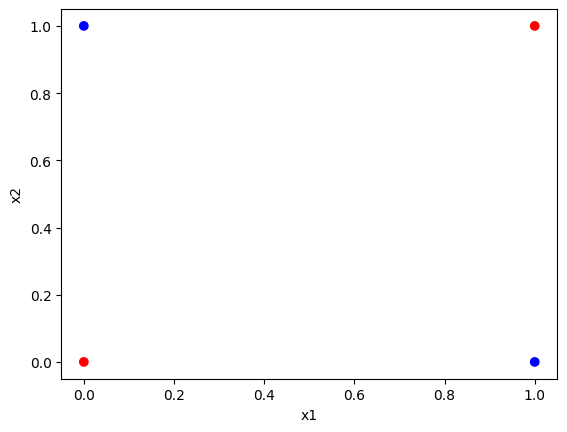

In [4]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<u><font color="maroon"> **Q2.** How does a NN solve the XOR problem? [1 marks]</font></u>


Mathematically, a neural network is a sequence of linear combinations and transformations on a set of inputs (input vectors) that can in theory model any function, no matter how complex. This is useful in the case of a classification case such as XOR, which is not linearly separable and thus not amenable to standalone linear classifiers. In the case of the XOR problem, a NN two or more hidden neurons (_each with its own weighted input sum and transformed output_) can be tuned to estimate a complex, non-linear function that can help classify XOR inputs (_note that an NN with one hidden neuron is essentially a single function on a linear combination of a single set of weights; not much better than a usual classifier_).

We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

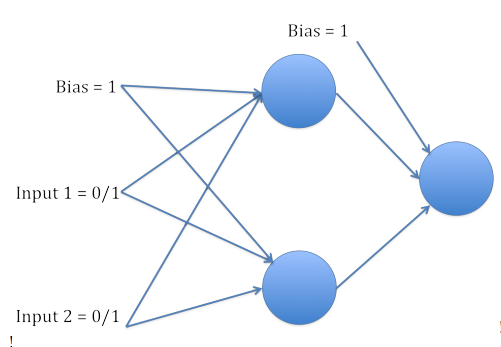

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [5]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs):
    super().__init__()
    self.hidden_layer = nn.ModuleList(
        [LogisticRegression(num_inputs) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList(
        [LogisticRegression(num_neurons+1) for i in range(num_outputs)])
        # NOTE: +1 for the bias

    # Other parameters for later use:
    self.gradient = None
    self.num_inputs = num_inputs
    self.y_hidden = None
    self.y_output = None
    self.x = None

  #============================================================

  def forward(self, x: torch.tensor) -> torch.tensor:
    y_hidden = torch.ones(len(self.hidden_layer)+1)
    y_output = torch.ones(len(self.output_layer))
    self.gradient = []
    self.x = x
    # NOTE: +1 for the bias
    """
    IMPLEMENTATION DETAILS:
    y_hidden & y_output are row vectors.
    NOTE: In this neural network, there is but one hidden layer.

    Each element of y_hidden (except the last, which is the bias term)
    corresponds to and is meant to store the output of the respective neuron
    of the hidden layer. y_hidden will serve as the input for the output layer.

    Each element of y_output (could be single-valued) corresponds to and is
    meant to store the output of the respect neuron of the output layer; there
    is no bias term here. y_output will be the output for this neural network.

    The list `gradient` stores the gradients as they are calculated in the
    forward pass method itself (to save computational cost and time overall).

    `self.x` simply stores the previous input to the forward method; this is
    useful for backward pass, which uses the same input.
    """
    # 1. Propagating input vector x through hidden layer:
    self.gradient.append([])
    for i, module in enumerate(self.hidden_layer):
      y_hidden[i] = module(x)
      self.gradient[-1].append((y_hidden[i]*(1-y_hidden[i])).item())

    # 2. Propagating output vector of the hidden layer through output layer:
    self.gradient.append([])
    for i, module in enumerate(self.output_layer):
      y_output[i] = module(y_hidden)
      self.gradient[-1].append((y_output[i])*(1-y_output[i]).item())

    for i in range(len(self.gradient)):
      self.gradient[i] = torch.tensor(self.gradient[i])

    # 3. Returning the final output vector (may be single-valued):
    self.y_hidden = y_hidden
    self.y_output = y_output
    return y_output

  #============================================================

  def backward_pass(self, y: torch.tensor, lr: float) -> None:
    """
    y is the vector of expected outputs (may be single-valued).
    """

    # Obtaining the partial derivatives for the output layer:
    # NOTE: 1 derivative per output-layer neuron
    delta_output = (self.y_output-y)*self.gradient[-1]
    # Storing the weights for each output layer:
    w_output = torch.ones(len(self.output_layer), len(self.hidden_layer)+1)
    for i, module in enumerate(self.output_layer):
      w_output[i] = module.weight
    self.gradient.pop()

    # Obtaining the partial derivatives for the hidden layer:
    # NOTE: 1 derivative per hidden-layer neuron
    delta_hidden = self.gradient[-1]*(w_output*delta_output).sum()
    # Storing the weights for each hidden layer:
    w_hidden = torch.ones(len(self.hidden_layer), self.num_inputs)
    for i, module in enumerate(self.hidden_layer):
      w_hidden[i] = module.weight
    self.gradient.pop()

    # Reshaping the vectors to make them amenable to the required operations:
    delta_hidden = delta_hidden.reshape(delta_hidden.shape[0], 1)
    x = self.x.reshape(1, self.x.shape[0])

    # Updating the weights:
    w_output -= lr*delta_output*self.y_hidden
    w_hidden -= lr*(delta_hidden @ x)

    for i, module in enumerate(self.output_layer):
      module.weight = nn.Parameter(w_output[i], requires_grad=False)
    for i, module in enumerate(self.hidden_layer):
      module.weight = nn.Parameter(w_hidden[i], requires_grad=False)

In [6]:
# Testing if it works:
x_test = torch.tensor([0., 1., 1.]) # Last term is the bias
y_test = torch.tensor([1.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print("Prediction:", model(x_test).item())
print(f"------------\nModel:\n{model}")
print("------------\nNamed parameters:")
for name, param in model.named_parameters(): print(name, param)
print('------------\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

Prediction: 0.6679260730743408
------------
Model:
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
------------
Named parameters:
hidden_layer.0.weight Parameter containing:
tensor([[-0.0225,  1.6093, -2.4691]])
hidden_layer.1.weight Parameter containing:
tensor([[-2.2078, -1.1555,  0.8045]])
output_layer.0.weight Parameter containing:
tensor([[-0.0594,  2.3787, -0.2662]])
------------
Hidden layer weight matrix:
tensor([[[-0.0225,  1.6093, -2.4691]],

        [[-2.2078, -1.1555,  0.8045]]])


In the `NeuralNetwork` class above, fill in the `backward_pass()` method.

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output $k$ (_here,_ $k$ _is the index of label given to the output neuron, not the actual output value_), calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$
  where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to propagate this error to the hidden neurons. To accomplish this remember that:

  $
  \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
  $

  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula:

  $
  w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
  $

  where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation:

  $
  w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
  $

  where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [7]:
# Test it works
# Requires the forward method to run first:
model(x_test)

# Printing the weights before & after to see if updates are happening:
print("BEFORE:")
print("Hidden layer weights:")
print(model.hidden_layer.state_dict())
print("Output layer weights:")
print(model.output_layer.state_dict())
model.backward_pass(y_test, 1)

print("\nAFTER:")
print("Hidden layer weights:")
print(model.hidden_layer.state_dict())
print("Output layer weights:")
print(model.output_layer.state_dict())

BEFORE:
Hidden layer weights:
OrderedDict([('0.weight', tensor([[-0.0225,  1.6093, -2.4691]])), ('1.weight', tensor([[-2.2078, -1.1555,  0.8045]]))])
Output layer weights:
OrderedDict([('0.weight', tensor([[-0.0594,  2.3787, -0.2662]]))])

AFTER:
Hidden layer weights:
OrderedDict([('0.weight', tensor([-0.0225,  1.6409, -2.4375])), ('1.weight', tensor([-2.2078, -1.1188,  0.8411]))])
Output layer weights:
OrderedDict([('0.weight', tensor([-0.0375,  2.4091, -0.1926]))])


Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

In [8]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor):
  # NOTE: bce ==> binary cross entropy
  J = (y_true*torch.log(y_pred) + (1-y_true)*torch.log(1-y_pred)).sum()
  return -J.item()

In [9]:
# XOR inputs & expected outputs (with bias term added at the end)
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
y = torch.tensor([0., 1., 1., 0.])
# Converting the above x-values into rows of binary pairs (as expected in XOR):
# NOTE: We are also adding a bias term to every row:
x = torch.cat((torch.stack([x1, x2]).permute(1, 0), torch.ones(4, 1)), dim=1)
print(x)

tensor([[0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])


Training loop...

In [10]:
def trainingLoop(nIterations=1000, lr=1.0):
  model, errors = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1), []
  for ep in range(nIterations):
    error = 0
    for i in range(x.shape[0]):
      y_pred = model(x[i])
      error += bce(y[i], y_pred)
      model.backward_pass(y[i], lr)
    errors.append(error/x.shape[0])

  # Returning the results:
  return model, errors

A loop to reinitialise the neural network model and restart the optimisation $n$ times and return the best model out of $n$...

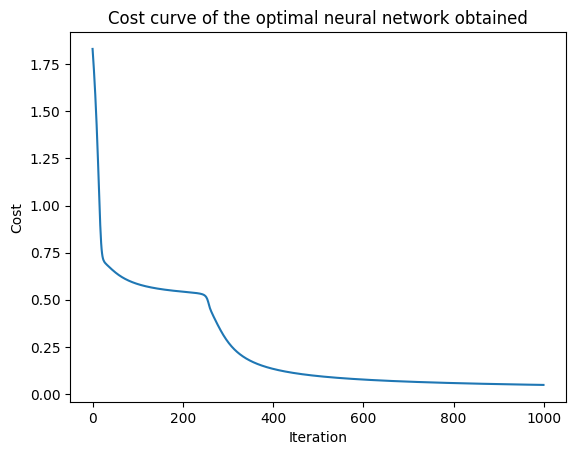


RESULTS:
y:0.0, prediction:0.041922565549612045
y:1.0, prediction:0.951196551322937
y:1.0, prediction:0.9509459733963013
y:0.0, prediction:0.04670383781194687

Final error obtained: 0.0478825569152832


In [11]:
nIterations, minErrors, bestModel = 1000, [float("inf")], NeuralNetwork(3, 2, 1)
for i in range(10):
  model, errors = trainingLoop(nIterations=nIterations, lr=1.0)
  # If the errors were minimised further:
  if errors[-1] < minErrors[-1]: bestModel, minErrors = model, errors

# Plotting the lowest error model:
plt.plot(list(range(nIterations)), minErrors)
plt.title("Cost curve of the optimal neural network obtained")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# Obtaining the best predictions:
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]): y_pred[i] = bestModel(x[i])

# Printing the results:
print("\nRESULTS:")
for i in range(len(y)):print(f"y:{y[i]}, prediction:{y_pred[i]}")
print("\nFinal error obtained:", minErrors[-1])

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [12]:
iris = datasets.load_iris(as_frame=True)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42)

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int().reshape(-1, 1)
y_test = torch.from_numpy(y_test.values).int().reshape(-1, 1)

# Normalization function from part 1 of this assignment:
def norm_set(x:torch.Tensor,mu:torch.Tensor,sigma:torch.Tensor)->torch.tensor:
  return (x-mu)/sigma

# Normalizing training & testing sets:
mu = {"x_train": torch.mean(x_train, 0)}
sigma = {"x_train": torch.std(x_train, 0)}
x_train = norm_set(x_train, mu["x_train"], sigma["x_train"])
x_test = norm_set(x_test, mu["x_train"], sigma["x_train"])

#x_train = torch.cat((x_train, torch.ones(x_train.shape[0], 1)), dim=1)
#x_test = torch.cat((x_test, torch.ones(x_test.shape[0], 1)), dim=1)

Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`.

<u><font color="maroon"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>

**IMPLEMENTATION NOTE 1**: `torch.nn.Linear` **simulating a layer of neurons**:<br>The class `torch.nn.Linear` simulates a whole layer of neurons. It takes in the following parameters into its constructor:

- `in_features`: The number of features each neuron of the layer accepts (i.e. the size of input vectors each neuron takes)
- `out_features`: The number of features the layer outputs (i.e. the number of neurons in the layer)
- `bias`: Whether bias term should be added or not

To simulate a layer whose each neuron takes `in_features` sized inputs and which has a `out_features` neurons, `nn.Linear` uses a matrix of randomised weights of dimensionality `in_features` $\times$ `out_features`. Note that matrix multiplication is essentially the resultant vector arising from a sequence of mutually independent (hence practically simultaneous) linear combinations between two ordered sets of vectors. This perfectly simulates a layer of multiple neurons simultaneously accepting `in_features` inputs each.

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

---

**IMPLEMENTATION NOTE 2**:<br>An activation function inputs and outputs vectors/matrices of the same dimensionality, i.e. it does not alter the dimensionality of its inputs. This makes them perfect for transforming the mapping of the linear combinations of vectors without altering the desired number of final outputs.


In [14]:
class NN:
  def __init__(self, nFeatures, nHidden, nLabels, alpha=0.5):
    self.model = nn.Sequential(nn.Linear(nFeatures, nHidden, bias=True), # (1)
                               nn.Softmax(dim=1),
                               nn.Linear(nHidden, nLabels, bias=True),   # (2)
                               nn.Softmax(dim=1))

    """
    (1): Hidden layer with nHidden neurons
    (2): Output layer with nLabels neurons
    """
    self.loss = nn.CrossEntropyLoss()
    self.optimiser = optim.SGD(self.model.parameters(), alpha)
    # SGD ==> Stochastic gradient descent

    self.nFeatures = nFeatures
    self.nHidden = nHidden
    self.nLabels = nLabels

  def train(self, x, y, xTest, yTest, alpha=0.1, nSteps=1000, axs=None):
    trainCostList = []
    testCostList = []

    for i in range(nSteps):
      self.model.train() # Setting the model to training mode
      self.optimiser.zero_grad()
      trainPred = self.model(x)

      # Backpropagation:
      trainCost = self.loss(trainPred, y)
      trainCost.backward()
      trainCostList.append(trainCost.item())
      self.optimiser.step()
      self.model.eval() # Setting the model to evaluation mode
      with torch.no_grad():
        testPred = self.model(xTest)
        testCost = self.loss(testPred, yTest)
        testCostList.append(testCost)

    # Plotting results:
    try:
      axs[0].plot(list(range(i+1)), trainCostList, label=str(self.nHidden))
      axs[1].plot(list(range(i+1)), testCostList, label=str(self.nHidden))
    except: pass
    return trainCostList[-1], testCostList[-1]

In [15]:
def getModels(x, y, xTest, yTest, nHiddenList=[1, 2, 4, 8, 16, 32], alpha=0.2, nSteps=5000):
  # Adding bias to the feature sets:
  x_biased = torch.cat((x, torch.ones(x.shape[0], 1)), dim=1)
  xTest_biased = torch.cat((xTest, torch.ones(xTest.shape[0], 1)), dim=1)
  # Converting y to one-hot format for matching the softmax activation output:
  y_oneHot = F.one_hot(y.reshape(-1).long(), num_classes=3).float()
  y_oneHotTest = F.one_hot(yTest.reshape(-1).long(), num_classes=3).float()

  # Plotting results:
  fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
  # Detailing the graph...
  axs[0].set_title("For training data"), axs[1].set_title("For testing data")
  axs[0].set_xlabel("Steps"), axs[1].set_xlabel("Steps")
  axs[0].set_ylabel("Cost"), axs[1].set_ylabel("Cost")
  finTrainCostList = {}
  finTestCostList = {}
  M = []
  for n in nHiddenList:
    M.append(NN(x_biased.shape[1], n, len(y.unique())))
    r = M[-1].train(x_biased, y_oneHot, xTest_biased, y_oneHotTest,
                    alpha=alpha, nSteps=nSteps, axs=axs)
    finTrainCostList[str(n)], finTestCostList[str(n)] = r

  axs[0].legend()
  axs[1].legend()
  plt.show()
  return M, finTrainCostList, finTestCostList

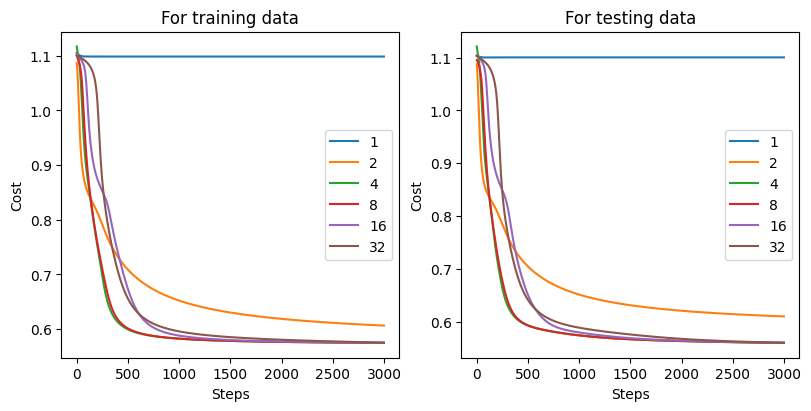


Minimum training cost obtained for each number of hidden nodes:
1 	| 1.0984039306640625
2 	| 0.6063951849937439
4 	| 0.5747485756874084
8 	| 0.5747442841529846
16 	| 0.5749698877334595
32 	| 0.5752428770065308

Minimum testing cost obtained for each number of hidden nodes:
1 	| 1.1004875898361206
2 	| 0.6096335053443909
4 	| 0.5595537424087524
8 	| 0.5594707727432251
16 	| 0.5596875548362732
32 	| 0.5597070455551147


In [33]:
M, r1, r2 = getModels(x_train, y_train, x_test, y_test, nSteps=3000, alpha=0.1)
print("\nMinimum training cost obtained for each number of hidden nodes:")
for k in r1: print(f"{k} \t| {r1[k]}")
print("\nMinimum testing cost obtained for each number of hidden nodes:")
for k in r2: print(f"{k} \t| {r2[k]}")

In the above graphs, the numbers 1, 2, 4, 8, 16 and 32 are the number of hidden nodes the respective model has (corresponding to that model's cost curve).

Having a look at the accuracy of the predictions (i.e. multiclass classification) of the above models...

In [34]:
def get_accuracy(x, y, m, K=3):
  # Adding bias to the feature set:
  x_biased = torch.cat((x, torch.ones(x.shape[0], 1)), dim=1)
  # Converting y to one-hot format for matching the softmax activation output:
  y_oneHot = F.one_hot(y.reshape(-1).long(), num_classes=3).float()

  a = 0
  P = m.model(x_biased)
  for i in range(x.shape[0]):
    pMax, jMax = 0, 0
    for j in range(K):
      p_ij = P[i, j]
      if p_ij > pMax: pMax, jMax = p_ij, j
    if y_oneHot[i, jMax] == 1: a += 1
  return a/y.shape[0]

In [35]:
print("ACCURACY")
print("Given hidden nodes...")
for m in M:
  aTrain = get_accuracy(x_train, y_train, m, 3)
  aTest = get_accuracy(x_test, y_test, m, 3)
  print(f"{m.nHidden} \t| training:{aTrain:.3f} \t testing:{aTest:.3f}")

ACCURACY
Given the number of hidden nodes...
1 	| training:0.342 	 testing:0.300
2 	| training:0.967 	 testing:0.967
4 	| training:0.983 	 testing:1.000
8 	| training:0.983 	 testing:1.000
16 	| training:0.983 	 testing:1.000
32 	| training:0.983 	 testing:1.000


**OBSERVATIONS**: **One vs. many logistic regression & the above neural network**:<br>For the same problem of classifying data points as one of three flowers (setosa, versicolor and virginica) based on the attributes (_sepal length, sepal width, petal length, petal width_) was approached in two ways:

1. The above neural network (NN)
2. The previous one vs. many logistic regression method

---

**Overfitting (or lack thereof)**...

 The previous one vs. many logistic regression model had the following results:

- Training accuracy: 0.850,
- Testing accuracy: 0.9

The levels of accuracy of the training and testing data being quite similar indicate a lack of overfitting in the model; hence, we can consider the model to be well generalised. We observe the same phenomenon with the neural networks, wherein the training and testing loss function values are similar to each other, no matter the number of hidden nodes. Hence, we can conclude that the neural network in this scenario does not overfit to the training data.

---

**Accuracy of NN**...

1.
_With respect to number of hidden nodes in the hidden layer_...

At one hidden node, the accuracy is abysmal, but rises rapidly with the second hidden node and stays more or less the same (above $0.95$) for all subsequent versions.

2.
_With respect to one vs. many multiclass classifier_...

The view of the accuracy of the neural network models given above show that with enough hidden nodes, the neural network tends to be more accurate than the one vs. many mutliclass classifier.